# Normal Sun Mode 2017:066 analysis

### __Content__

1. __Star acquisition during the observations prior to entering the NSM__

1. __Attitude offset from the planned direction__

In [1]:
from Chandra.Time import DateTime
DateTime(605275821.184).date

'2017:066:12:09:12.000'

### __Summary__

* The NSM entry occurred at 2017:066:00:24:21 at the end of the maneauver from ObsID 50260 to ObsID 50259.

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pylab as plt
from astropy.table import Table
from astropy.io import ascii
import astropy.units as u
import Ska.engarchive.fetch as fetch
import Ska.quatutil as quatutil
from Ska.Matplotlib import plot_cxctime
from Chandra.Time import DateTime
from chandra_aca.plot import plot_stars
from Quaternion import Quat
from kadi import events
#from itertools import izip, count
import agasc

In [3]:
import Ska.engarchive.fetch as fetch
from Ska.Matplotlib import plot_cxctime

In [4]:
from mica.archive import aca_l0, asp_l1
import Ska.arc5gl
import os

In [5]:
keys = ['aoacmag', 'aoacyan', 'aoaczan']
slots = range(8)
msids_star = []
for slot in slots:
    msids = [key + np.str(slot) for key in keys]
    msids_star = msids_star + msids

### Star acquistion and identification ###

Maneuvers prior to the Normal Sun Mode:
1. Maneuver to ObsID=20025.
2. Maneuver to ObsID=50260.
3. Maneuver to ObsID=50259 (ended with the NSM transition).

In [6]:
# https://icxc.cfa.harvard.edu/mp/mplogs/2017/MAR0617/oflsa/starcheck.html#obsid50260

obsids = [20025, 50260, 50259]

manvrs = events.manvrs.filter(start='2017:065:16:50:00.000',
                              stop='2017:066:00:30:00.000')

rows = []
for i, manvr in enumerate(manvrs):
    row = {'no': i + 1, 'start': manvr.start, 'stop': manvr.stop,
           'one_shot': manvr.one_shot, 'dur': manvr.dur,
           'tstart': manvr.tstart, 'tstop': manvr.tstop,
           'to_obsid': obsids[i]}
    rows.append(row)

tab = Table(rows,
            names=('no', 'start', 'stop', 'one_shot',
                   'tstart', 'tstop', 'dur', 'to_obsid'),
            dtype=('i2', 'S20', 'S20', 'f4',
                   'f8', 'f8', 'f4', 'i4'))
print(tab['no', 'start', 'stop', 'dur', 'one_shot', 'to_obsid'])

 no        start                 stop           dur   one_shot to_obsid
--- -------------------- -------------------- ------- -------- --------
  1 2017:065:17:09:59.72 2017:065:17:24:51.47  891.75    5.064    20025
  2 2017:065:23:44:41.33 2017:065:23:48:41.18  239.85  6.28957    50260
  3 2017:065:23:54:39.93 2017:066:00:23:14.75 1714.83    -99.0    50259


### OBSID=50260 ###

In [7]:
# Fetch aoacmag, aoacyan, aoaczan telemetry
start = tab['tstart'][1]
stop = tab['tstop'][2] - 1400
telem = fetch.MSIDset(msids_star, start=start, stop=stop)

In [8]:
# Define reference times for average mag, yan, zan calculations
start_av = tab['tstop'][1] + 180
stop_av = tab['tstart'][2] - 5

times = [[start_av, stop_av]] * 6
times.insert(4, [start_av - 5, stop_av - 125])
times.append([start_av + 95, stop_av])

White: ObsID 50260
Gray: Maneuvers


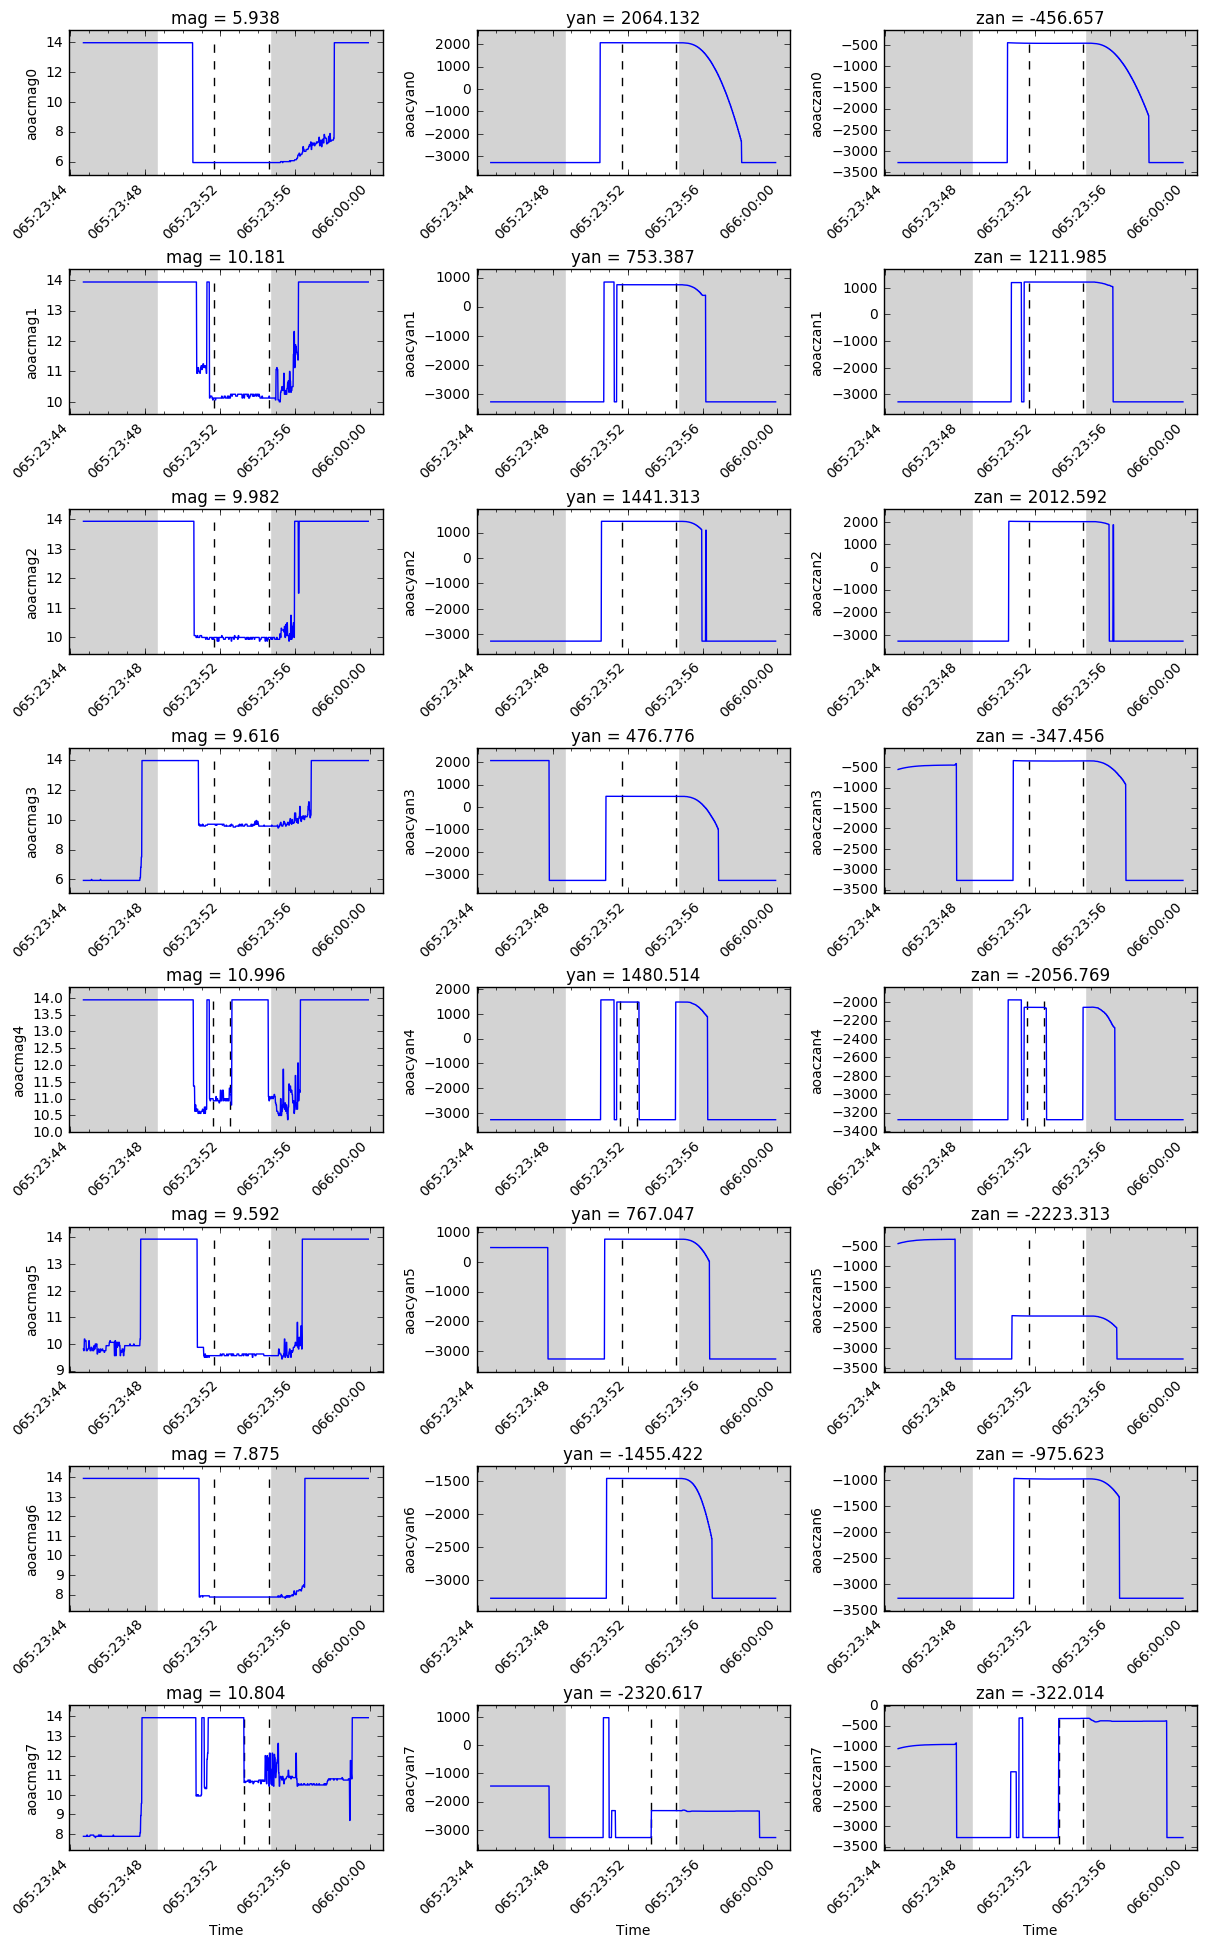

In [9]:
plt.figure(figsize=(12, 26))

rows = []
row = {}

for idx, msid in enumerate(msids_star):
    # Plot
    plt.subplot(8, 3, idx + 1, axisbg='lightgray')
    plot_cxctime(telem[msid].times, telem[msid].vals)
    plt.ylabel(msid)
    plt.xlabel("Time")
    plt.margins(0.05)  
    
    t1, t2 = times[idx // 3]
    times_mean = (telem[msid].times > t1) & (telem[msid].times < t2)
    # Average mag, yan, zan
    average = telem[msid].vals[times_mean].mean()
    plt.title('{} = {:.3f}'.format(msid[4:7], average))
    
    row[msid[:-1]] = average
    
    if np.mod(idx, 3) == 2:
        rows.append(row)
        row = {}

# Mark obsid time span (white) and reference times (dashed lines)
start_50260 = DateTime(tab['tstop'][1]).plotdate
stop_50260 = DateTime(tab['tstart'][2]).plotdate

for idx, ax in enumerate(plt.gcf().axes):
    plt.setp(ax.get_xticklabels(), visible=True, rotation=45, ha='right')
    ax.axvspan(start_50260, stop_50260, ymin=-5000, ymax=5000, color='white')
    av_times = DateTime(times[idx // 3]).plotdate
    ax.vlines(av_times, ax.get_ylim()[0], ax.get_ylim()[1], color='k', linestyle='--')
        
plt.subplots_adjust(left=0.05, bottom=0.2, right=0.99, top=0.9, wspace=0.3, hspace=0.65)

print('White: ObsID 50260')
print('Gray: Maneuvers')

In [10]:
t_50260 = Table(rows)

In [11]:
print(t_50260['aoacyan', 'aoaczan', 'aoacmag'])

   aoacyan        aoaczan     aoacmag
-------------- -------------- -------
 2064.13224852 -456.656508876  5.9375
 753.386538462   1211.9852071 10.1812
 1441.31301775  2012.59215976 9.98151
 476.775887574  -347.45591716 9.61649
 1480.51442308    -2056.76875 10.9964
 767.047189349 -2223.31331361 9.59209
-1455.42204142 -975.623224852   7.875
-2320.61655844 -322.014285714 10.8036


In [12]:
# Kadi, attitude solution:
#
# Attitude solution
# Coordinates
#
# RA=216.520438565
# Dec=37.8175070255
# Roll=113.948805195
#
# Q1=0.0808060206211
# Q2=-0.808580431808
# Q3=-0.404505046175
# Q4=0.419575666534
#
#  
# Star match summary and residuals 
#
# slot      YAG            ZAG       MAG_ACA  m_yag     dy   m_zag     dz   dr  m_agasc_id
# ---- -------------- -------------- ------- -------- ----- -------- ----- ---- ----------
#   0  2064.13224852 -456.656508876  5.9375  2064.14 -0.01  -457.00  0.34 0.34  397805704
#   1  753.386538462   1211.9852071 10.1812       --    --       --    --   --         --
#   2  1441.31301775  2012.59215976 9.98151  1441.34 -0.03  2013.30 -0.71 0.71  397807608
#   3  476.775887574  -347.45591716 9.61649   476.77  0.01  -347.63  0.17 0.17  397808560
#   4  1480.51442308    -2056.76875 10.9964       --    --       --    --   --         --
#   5  767.047189349 -2223.31331361 9.59209   767.44 -0.39 -2223.73  0.42 0.57  397940208
#   6 -1455.42204142 -975.623224852   7.875 -1455.85  0.42  -975.40 -0.22 0.48  397943760
#   7 -2320.61655844 -322.014285714 10.8036       --    --       --    --   --         --

q_kadi = Quat([0.0808060206211, -0.808580431808, -0.404505046175, 0.419575666534])

# Starcheck, OBSID=50250
# MP_TARGQUAT at 2017:065:23:42:34.790 (VCDU count = 6623524)
# Q1,Q2,Q3,Q4: 0.08097196  -0.80871127  -0.40423026  0.41955635

q_planned = Quat([0.08097196, -0.80871127, -0.40423026, 0.41955635])

dq = q_kadi.dq(q_planned)

print('d(Roll) = {:.1f} arcsec'.format(dq.roll0 * 3600))
print('d(Pitch) = {:.1f} arcsec'.format(dq.pitch * 3600))
print('d(Yaw) = {:.1f} arcsec'.format(dq.yaw * 3600))

offset = agasc.agasc.sphere_dist(q_kadi.ra, q_kadi.dec, q_planned.ra, q_planned.dec)
offset = (offset * u.deg).to('arcsec').value

print('\nOffset = {:.1f} arcsec'.format(offset))
print('One_shot = {:.1f} arcsec'.format(tab['one_shot'][1]))

d(Roll) = 142.9 arcsec
d(Pitch) = 7.8 arcsec
d(Yaw) = -6.6 arcsec

Offset = 10.2 arcsec
One_shot = 6.3 arcsec


__ Relative centroids __

In [13]:
def relative_centroids(slots, key, colors, title=''):
    for slot, color in zip((0, 1, 2, 3, 5, 6), colors):
        coord = fetch.Msid(key + '{}'.format(slot), times[slot][0], times[slot][1])
        coord.select_intervals(events.dwells(pad=-35))
        plot_cxctime(coord.times, coord.vals - coord.vals[0], color, 
                     label='Slot {}'.format(slot), lw=1.5)
    plt.margins(0.05)
    plt.grid()
    #plt.legend(loc=(1.1, 0.1))
    plt.title(title);
    return

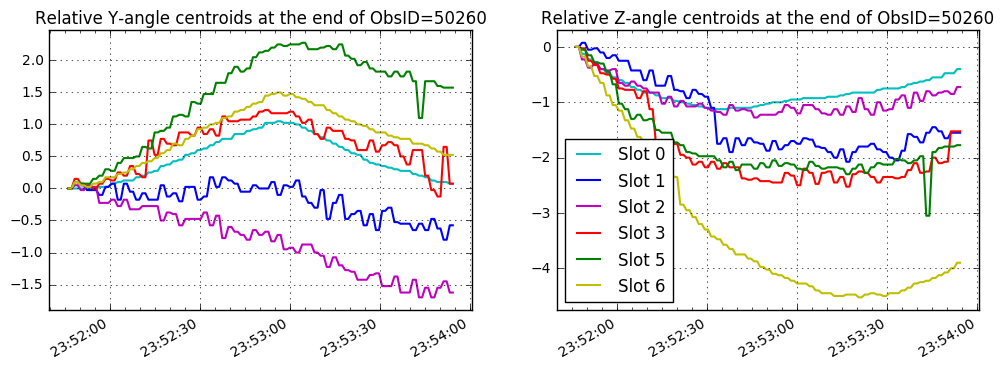

In [14]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
relative_centroids((0, 1, 2, 3, 5, 6), 'aoacyan', 'cbmrgy',
                   'Relative Y-angle centroids at the end of ObsID=50260')
plt.subplot(1, 2, 2)
relative_centroids((0, 1, 2, 3, 5, 6), 'aoaczan', 'cbmrgy',
                   'Relative Z-angle centroids at the end of ObsID=50260')
plt.legend(loc='best');

In [16]:
msids_gb = ['aogbias1', 'aogbias2', 'aogbias3']
axes = ['Roll', 'Pitch', 'Yaw']
colors = 'bgm'

In [17]:
start = tab['tstop'][1]
stop = tab['tstop'][2]
telem_gb = fetch.MSIDset(msids_gb, start=start, stop=stop)

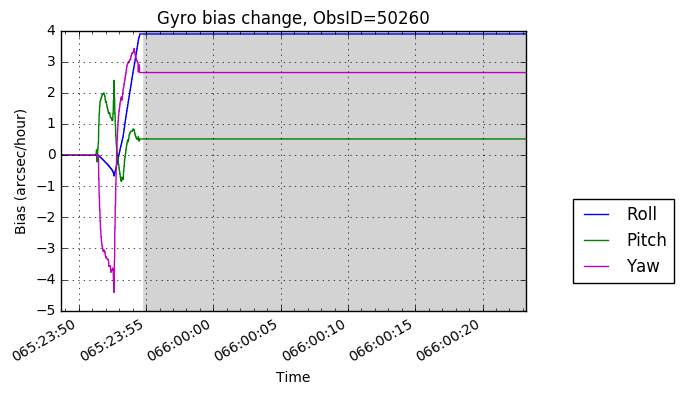

In [18]:
plt.figure()
plt.subplot(1, 1, 1, axisbg='lightgray')
colors = 'bgm'
for i, msid in enumerate(msids_gb):
    plot_cxctime(telem_gb[msid].times,
                 ((telem_gb[msid].vals - telem_gb[msid].vals[0]) * u.radian / u.s).to('arcsec/hr'),
                 color=colors[i], label=axes[i])

plt.ylabel('Bias (arcsec/hour)')
plt.xlabel('Time')
plt.title('Gyro bias change, ObsID=50260')
plt.grid()
ylim = [-20, 20]
ax = plt.gca()
ax.axvspan(start_50260, stop_50260, ymin=-5000, ymax=5000, color='white')
plt.legend(loc=(1.1, 0.1));

### OBSID=50259 ###

In [19]:
# Fetch aoacmag, aoacyan, aoaczan telemetry
start = tab['tstop'][2]
stop = '2017:066:00:28:00'
time_nsm = '2017:066:00:24:21'
telem = fetch.MSIDset(msids_star, start=start, stop=stop)

In [29]:
# Define reference times for average mag, yan, zan calculations
#start_av = DateTime('2017:066:00:24:05.000').secs
#stop_av = DateTime('2017:066:00:24:20.000').secs
start_av = DateTime('2017:066:00:25:35.000').secs
stop_av = DateTime('2017:066:00:25:45.000').secs
times = [start_av, stop_av]

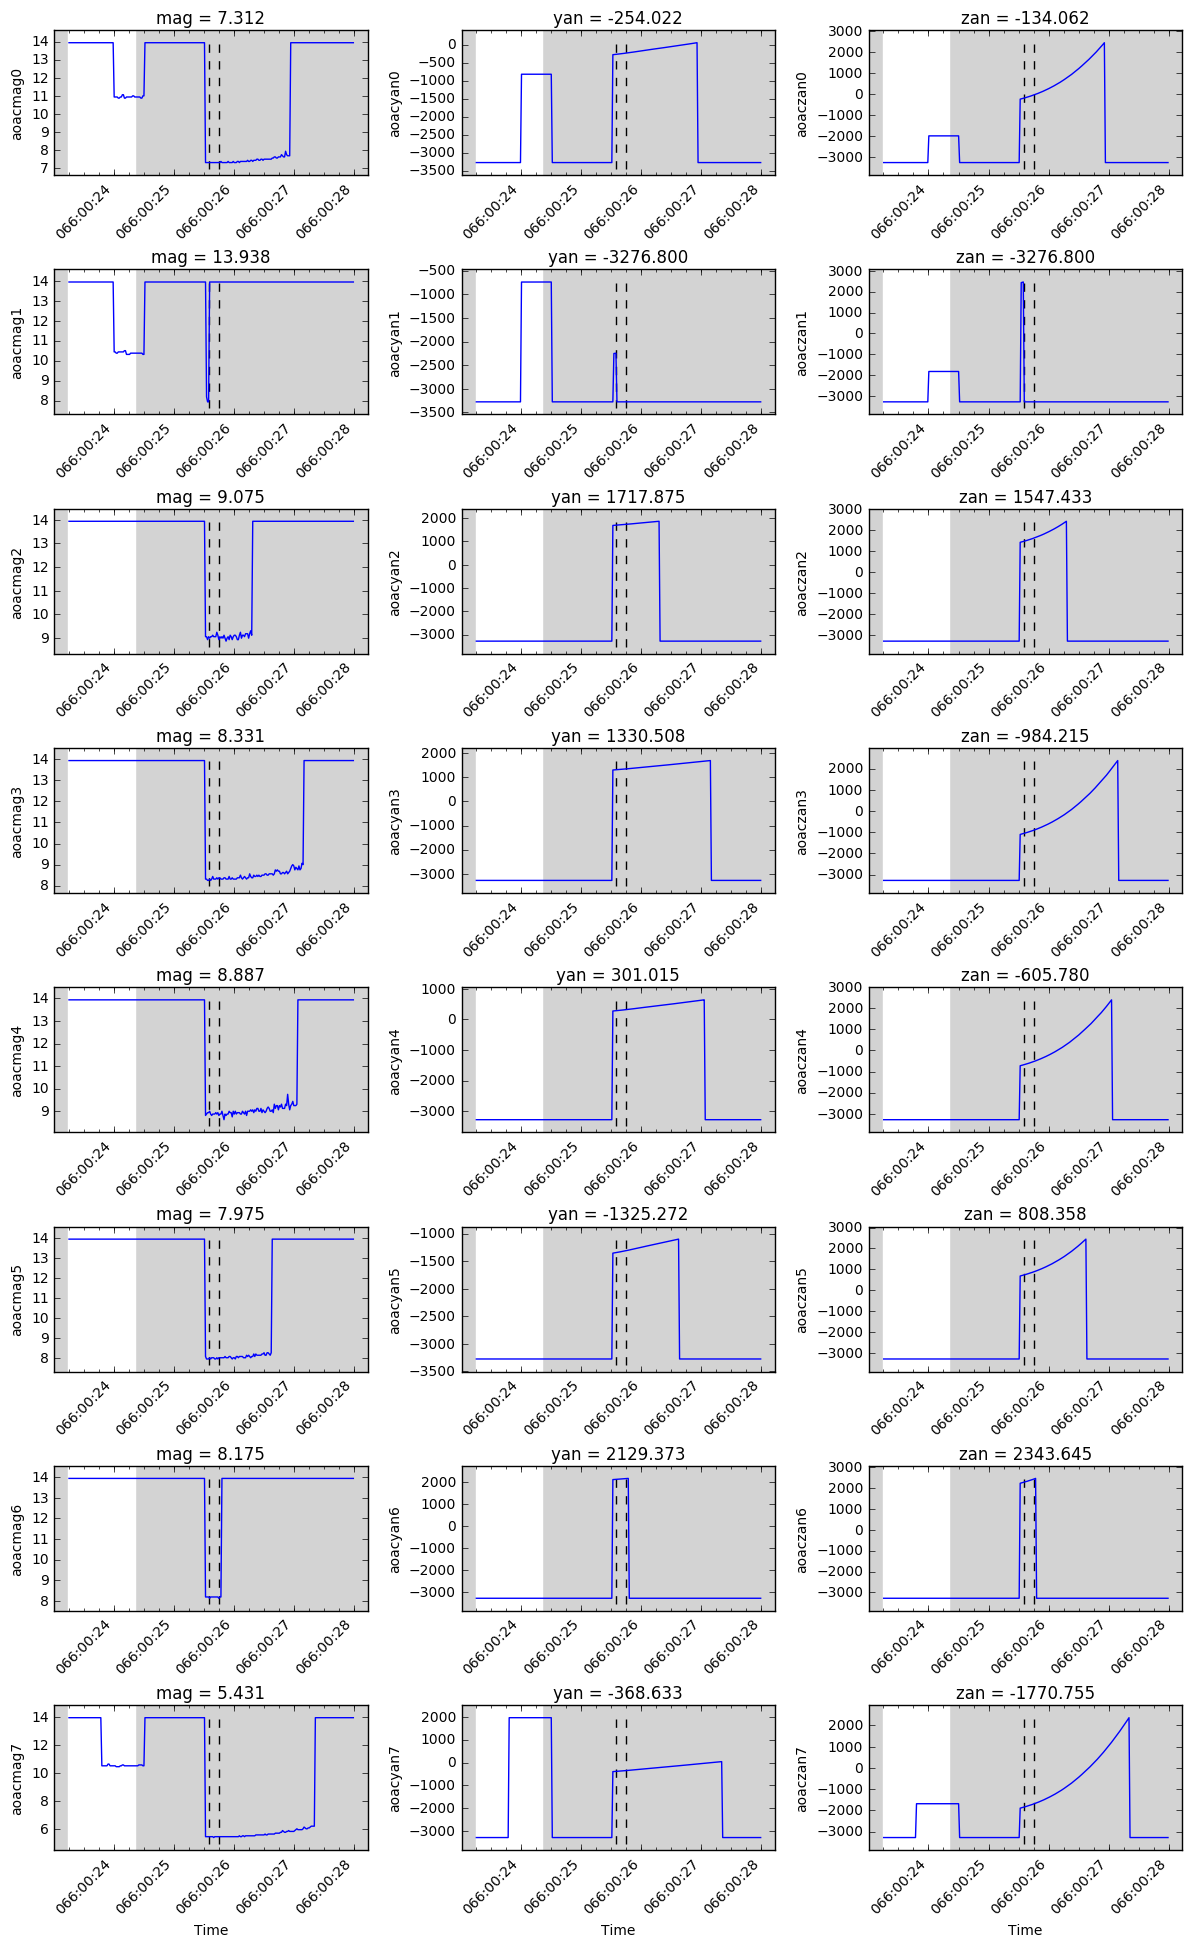

In [30]:
plt.figure(figsize=(12, 26))

rows = []
row = {}

for idx, msid in enumerate(msids_star):
    # Plot
    plt.subplot(8, 3, idx + 1, axisbg='lightgray')
    plot_cxctime(telem[msid].times, telem[msid].vals)
    plt.ylabel(msid)
    plt.xlabel("Time")
    plt.margins(0.05)
    
    times_av = (telem[msid].times > times[0]) & (telem[msid].times < times[1])
    # Average mag, yan, zan
    average = telem[msid].vals[times_av].mean()
    plt.title('{} = {:.3f}'.format(msid[4:7], average))
    row[msid[:-1]] = average
    
    if np.mod(idx, 3) == 2:
        rows.append(row)
        row = {}

# Mark obsid time span (white) and reference times (dashed lines)
start_50259 = DateTime(start).plotdate
stop_50259 = DateTime(time_nsm).plotdate

for idx, ax in enumerate(plt.gcf().axes):
    plt.setp(ax.get_xticklabels(), visible=True, rotation=45, ha='right')
    ax.axvspan(start_50259, stop_50259, ymin=-5000, ymax=5000, color='white')
    #if idx // 3 in [0, 1, 7]:
    ax.vlines(DateTime(times).plotdate, ax.get_ylim()[0], ax.get_ylim()[1],
              color='k', linestyle='dashed')

plt.subplots_adjust(left=0.05, bottom=0.2, right=0.99, top=0.9, wspace=0.3, hspace=0.65)

In [27]:
t_50259_1 = Table(rows)

In [28]:
print(t_50259_1['aoacyan', 'aoaczan', 'aoacmag'])

   aoacyan        aoaczan     aoacmag
-------------- -------------- -------
-824.561666667 -2005.04333333   10.95
       -741.21      -1822.615 10.3958
       -3276.8        -3276.8 13.9375
       -3276.8        -3276.8 13.9375
       -3276.8        -3276.8 13.9375
       -3276.8        -3276.8 13.9375
       -3276.8        -3276.8 13.9375
 1956.51833333 -1684.53333333 10.5042


In [31]:
t_50259_2 = Table(rows)

In [32]:
print(t_50259_2['aoacyan', 'aoaczan', 'aoacmag'])

 aoacyan    aoaczan  aoacmag
---------- --------- -------
 -254.0225 -134.0625  7.3125
   -3276.8   -3276.8 13.9375
  1717.875 1547.4325   9.075
 1330.5075  -984.215 8.33125
   301.015   -605.78  8.8875
-1325.2725  808.3575   7.975
 2129.3725  2343.645   8.175
 -368.6325 -1770.755 5.43125


In [33]:
# Kadi, find_attitude
#
# Attitude solution
# Coordinates
#
# RA=150.482797191
# Dec=31.4600014382
# Roll=214.946139993
#
# Q1=-0.155176988816
# Q2=-0.908581415465
# Q3=0.213601249838
# Q4=0.323688769779
#
#  
# Star match summary and residuals 
#
# slot    YAG        ZAG    MAG_ACA  m_yag     dy   m_zag     dz   dr  m_agasc_id
# ---- ---------- --------- ------- -------- ----- -------- ----- ---- ----------
#   0  -254.0225 -134.0625  7.3125  -254.21  0.19  -134.14  0.08 0.20  328081352
#   2   1717.875 1547.4325   9.075  1717.94 -0.06  1547.53 -0.10 0.12  328078016
#   3  1330.5075  -984.215 8.33125  1330.83 -0.32  -984.24  0.02 0.32  327951064
#   4    301.015   -605.78  8.8875   301.08 -0.06  -605.86  0.08 0.10  328081440
#   5 -1325.2725  808.3575   7.975 -1325.36  0.09   808.60 -0.24 0.26  328078824
#   6  2129.3725  2343.645   8.175  2129.20  0.18  2343.40  0.24 0.30  328081232
#   7  -368.6325 -1770.755 5.43125  -368.63 -0.01 -1770.67 -0.08 0.08  328085344

q_kadi = Quat([-0.155176988816, -0.908581415465, 0.213601249838, 0.323688769779])

# OBSID = 50259
# MP_TARGQUAT at 2017:065:23:54:34.470 (VCDU count = 6626333)
#  Q1,Q2,Q3,Q4: -0.15519481  -0.90893399  0.21402725  0.32240644
q_planned = Quat([-0.15519481, -0.90893399, 0.21402725, 0.32240644])

dq = q_kadi.dq(q_planned)

print('d(Roll) = {:.1f} arcsec'.format(dq.roll0 * 3600))
print('d(Pitch) = {:.1f} arcsec'.format(dq.pitch * 3600))
print('d(Yaw) = {:.1f} arcsec'.format(dq.yaw * 3600))

offset = agasc.agasc.sphere_dist(q_kadi.ra, q_kadi.dec, q_planned.ra, q_planned.dec)
offset = (offset * u.deg).to('arcsec').value

print('\nOffset = {:.1f} arcsec'.format(offset))

d(Roll) = 43.9 arcsec
d(Pitch) = -553.4 arcsec
d(Yaw) = 153.9 arcsec

Offset = 574.4 arcsec


###  OBSID=20025###

In [34]:
from itertools import cycle
def plot_att_changes(refs, atts, label):
    drs = []
    dps = []
    dys = []
    for ref_q, att_q in zip(cycle(refs['q_att']), atts['q_att']):
        dq = Quat(ref_q).dq(att_q)
        drs.append(dq.roll0 * 3600)
        dps.append(dq.pitch * 3600)
        dys.append(dq.yaw * 3600)

    plot_cxctime(obc_sol['time'], drs, '-b', label='Roll')
    plot_cxctime(obc_sol['time'], dps, '-g', label='Pitch')
    plot_cxctime(obc_sol['time'], dys, '-m', label='Yaw')
    plt.grid()
    plt.margins(0.05)
    plt.title('{}'.format(label))
    plt.ylabel('Change (arcsec)')
    plt.legend(loc='best');

### On-board and ground attitude solutions ###

In [35]:
solfiles = asp_l1.get_files(obsid=20025, revision='last', content='ASPSOL')

In [36]:
solfiles

['/data/aca/archive/asp1/20/20025_v02/pcadf605208435N002_asol1.fits.gz']

In [37]:
grnd_sol = Table.read(solfiles[-1])

In [38]:
obcfile = 'pcadf605224454N001_osol1.fits.gz'
if not os.path.exists(obcfile):
    arc5gl = Ska.arc5gl.Arc5gl()
    arc5gl.sendline('obsid=20025')
    arc5gl.sendline('version=last')
    arc5gl.sendline('get asp1{obcsol}')
    del arc5gl

In [39]:
obc_sol = Table.read(obcfile)

In [40]:
#ok = np.isclose(grnd_sol['time'], obc_sol[0]['time'], rtol=0, atol=0.01)
grnd_sol2 = grnd_sol[62512:-21][::4]
np.max(obc_sol['time'] - grnd_sol2['time'])

0.0

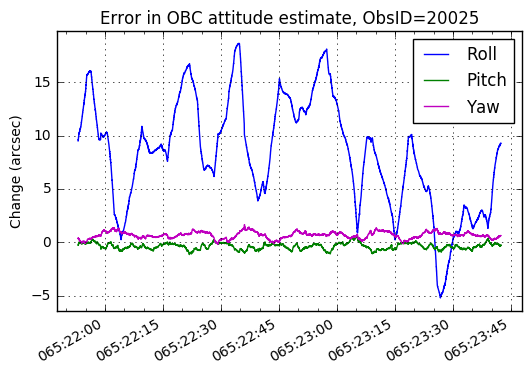

In [41]:
plot_att_changes(refs=grnd_sol2, atts=obc_sol,
                 label='Error in OBC attitude estimate, ObsID=20025')

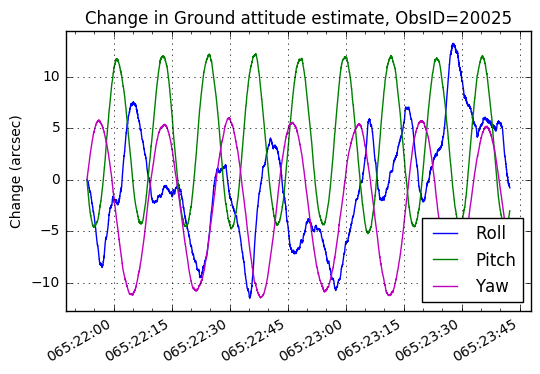

In [42]:
plot_att_changes(refs=grnd_sol2[:1], atts=grnd_sol2, 
                 label='Change in Ground attitude estimate, ObsID=20025')

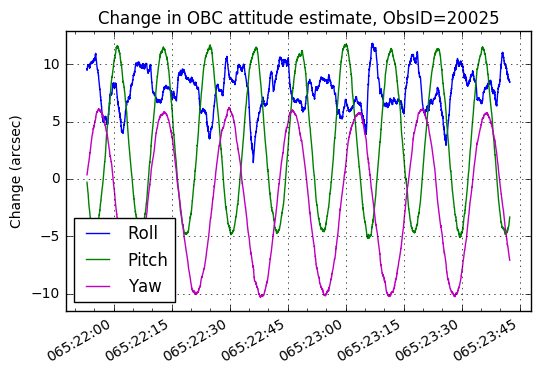

In [43]:
plot_att_changes(refs=grnd_sol2[:1], atts=obc_sol,
                 label='Change in OBC attitude estimate, ObsID=20025')

### Gyro bias change ###

In [44]:
start = tab['tstop'][0]
stop = tab['tstop'][2]
telem_gb = fetch.MSIDset(msids_gb, start=start, stop=stop)

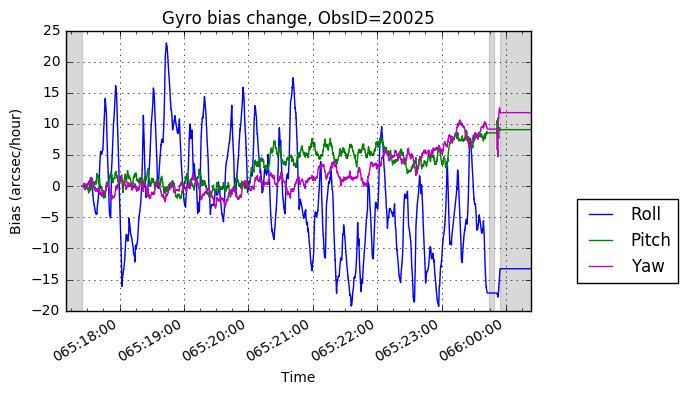

In [45]:
#fig = plt.figure(figsize=(12, 3))
for i, msid in enumerate(msids_gb):
    plot_cxctime(telem_gb[msid].times,
                 ((telem_gb[msid].vals - telem_gb[msid].vals[0]) * u.radian / u.s).to('arcsec/hr'),
                 color=colors[i], label=axes[i])

plt.ylabel('Bias (arcsec/hour)')
plt.xlabel('Time')
plt.title('Gyro bias change, ObsID=20025')
plt.grid()
ylim = [-20, 20]
mtimes = list(tab['tstart']) + list(tab['tstop'])
# mark start and end of the maneuvers
ax = plt.gca()
for v1, v2 in zip(tab['tstart'], tab['tstop']):
    ax.axvspan(DateTime(v1).plotdate, DateTime(v2).plotdate, ylim[0], ylim[1], alpha=0.3, color='gray')
plt.legend(loc=(1.1, 0.1));

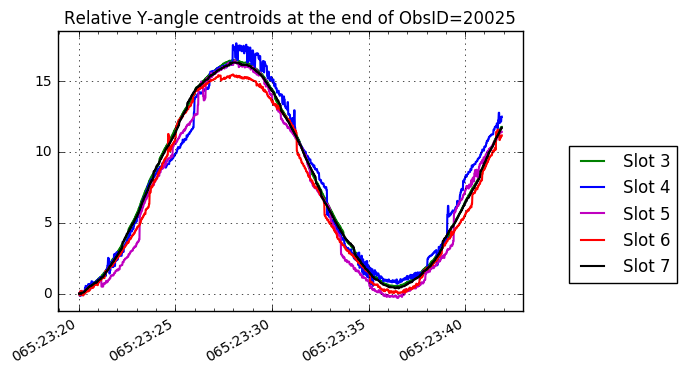

In [46]:
colors = 'gbmrk'

start = '2017:065:23:20:00.000'
stop = '2017:065:23:50:00.000'

for slot, color in zip((3, 4, 5, 6, 7), colors):
    yan = fetch.Msid('aoacyan{}'.format(slot), start, stop)
    yan.select_intervals(events.dwells(pad=-35))
    plot_cxctime(yan.times, yan.vals - yan.vals[0], color, 
                 label='Slot {}'.format(slot), lw=1.5)
plt.margins(0.05)
plt.grid()
plt.legend(loc=(1.1, 0.1))
plt.title('Relative Y-angle centroids at the end of ObsID=20025');